In [1]:
import pandas as pd
import xlrd
import requests
import numpy as np
from bs4 import BeautifulSoup
import re
import fnmatch
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import json
import pickle
import csv
from datetime import datetime
from datetime import timedelta
from dateutil import parser
%matplotlib inline
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import pytz

In [2]:
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

### Create dataframe of economic indicators by month Jan 1945 - Dec 2009

In [2]:
df_econ = pd.read_excel("Luther_excel.xlsx",set_index=True)

In [3]:
df_econ.columns = ['Month','USREC']
df_econ['Month'] = df_econ['Month'].map(lambda x: datetime.date(x))
df_econ.head()

,Month,USREC
0,1945-01-01,0
1,1945-02-01,0
2,1945-03-01,1
3,1945-04-01,1
4,1945-05-01,1


In [4]:
#### Create list of recessionary periods (by month)

rec_months = list(df_econ[df_econ['USREC']==1].Month)

### Scrape actors names, total gross and number of movies from Box Office Mojo

actors_FULL,tot_gross_FULL,num_movies_FULL = [],[],[]
pages = [1,2,4,8]

for i in pages:
    
    url = "http://www.boxofficemojo.com/people/?view=Actor&pagenum="+str(i)+"&sort=sumgross&order=DESC&adjust_yr=2015&adjust_mo=&&p=.htm"
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"html.parser")
    
    #ACTORS
    for link in soup.find_all('a',attrs = {'href':re.compile('/chart/')}):
        [actors_FULL.append(str(a.text)) for a in link.find_all('b')]    
    
    #TOTAL GROSS
    for link in soup.find_all('td',attrs = {'align':"right"}):
        [tot_gross_FULL.append(g.text.replace("$","").replace(",","").replace("k","")) 
         for g in link.find_all('b')]
   
    for n in soup.find_all('td')[12::7]:
        num_movies_FULL.append(int(n.text))

### Create dataframe with data from Box Office Mojo

    tot_gross_fl_FULL = [float(x) for x in tot_gross_FULL]
    d = zip(actors_FULL,tot_gross_fl_FULL,num_movies_FULL)
    df = pd.DataFrame(d)
    df.columns = ['Actor','Total_Gross_2015_Dol','Num_Movies']
    df = df.drop(df.index[726:])
    df['Avg_Gross'] = (df['Total_Gross_2015_Dol']/df['Num_Movies']).astype(float)


### Scrape Oscar data from 1980 - 2014

In [292]:
categories = range(1061,1065)

for c in categories:
    url = "http://awardsdatabase.oscars.org/ampas_awards/BasicSearch"
    data = {'action': 'performSearch',
                'BSFromYear': 53,
                'BSToYear': 87,
                'BSCategory': c,
               'displayType': 1}
    response = requests.post(url, data=data)

    page = response.text
    soup = BeautifulSoup(page,"html.parser")

    for name in soup.find_all('a',attrs = {'href':re.compile('BSNominationID')}):
            osc_names.append(name.text)

In [299]:
len(l_oscars)

1090

In [297]:
### Convert Oscar winners/nominees to strings
#### And create column based on Oscar win/nomination    
    
l_oscars = []

for name in osc_names:
    try:
        l_oscars.append(str(name))
    except:
        continue
            
df['Oscar']=df['Actor'].map(lambda x: 1 if x in l_oscars else 0)

### Write birthday data for every actor in df to csv file birthdays.csv    
    
    with open("birthdays.csv", 'a') as f: 
        writer=csv.writer(f)

        for actor in df.Actor[700:]:
            new_name = actor.replace(" ","_")
            url = "https://en.wikipedia.org/wiki/"+new_name

            response = requests.get(url)
            page = response.text
            soup = BeautifulSoup(page,"html.parser")

        #for line in soup.find_all('span',attrs = {'class':re.compile('BSNominationID')}):):
            try:
                for line in soup.find(class_="bday"):
                    writer.writerow((actor,line))
            except:
                writer.writerow((actor,None))


#### Strip white space off birthdays when reading csv data

    def strip(text):
        try:
            return text.strip().replace('\n',", ")
        except AttributeError:
            return text

#### Merge birthday data into dataframe

    df_birthdays = pd.read_csv("birthdays.csv", converters={'Birthday':strip})
    new_df = pd.merge(df,df_birthdays,on='Actor',how='outer')

### Search for occupations on Wikipedia by Actor name

    with open("occupations.csv", 'a') as f: 
        writer=csv.writer(f)

        for actor in df.Actor[700:]:
            new_name = actor.replace(" ","_")
            url = "https://en.wikipedia.org/wiki/"+new_name

            response = requests.get(url)
            page = response.text
            soup = BeautifulSoup(page,"html.parser")

            try:
                writer.writerow((actor,soup.find(class_="role").text))
            except:
                try:
                    writer.writerow((actor,soup.find(scope_="Occupation").text))
                except:
                    try: 
                        url = "https://en.wikipedia.org/wiki/"+new_name+"_(actor)"
                        response = requests.get(url)
                        page = response.text
                        soup = BeautifulSoup(page,"html.parser")
                        writer.writerow((actor,soup.find(class_="role").text))
                    except:
                        try:
                            writer.writerow((actor,soup.find(scope_="Occupation").text))
                        except:
                            writer.writerow((actor,"None"))               

#### Read Occupations data
    df_occ = pd.read_csv("occupations.csv", converters={'Occupation':strip})

#### Create Gender columm
    df_occ['Gender']=df_occ['Occupation'].map(lambda x: 0 if "actor" in x.lower() 
                                          else 1 if "actress" in x.lower() else "Unknown")

#### Dummy for people with Actors as principal occupation
    df_occ['Occ_act_dummy'] = df_occ['Occupation'].map(lambda x: 1 if x.lower().startswith("actor") or x.lower().startswith("actress") else "None" if x=="None" else 0)

#### Merge occupations data with original dataset
    full_df = pd.merge(df,df_occ,on='Actor',how='outer')

#### Trying to convert Birthday data into datetime objects

    full_df[full_df['Birthday'].notnull()]

    full_df['Birthday'] = full_df['Birthday'].fillna(0)

    full_df['Birthday'] = pd.to_datetime(full_df['Birthday'])

    full_df['Birthday'] = full_df['Birthday'].map(lambda x: datetime.strptime(str(x).replace(" ",""),"%Y-%m-%d"))

#### Dump dataframe

    with open('actors_oscars_birthday_2.pkl', 'w') as picklefile:
        pickle.dump(full_df, picklefile)

#### Load dataframe

    with open('actors_oscars_birthday_2.pkl', 'r') as picklefile:
        df = pickle.load(picklefile)

#### Clean whitespaces off birthday    
    df['Birthday'] = df['Birthday'].map(lambda x: str(x).replace(" ",""))

#### Check for whitespace in birthdays

    for n in df.Birthday:
        if type(n)==str:
            if len(n)>10:
                print n

#### Set a new value (example)

    new_df = df.set_value(682, 'Birthday', "1978-06-20")

#### Create dummy to measure principal occupation as Actor (1) or otherwise (0)

    new_df['Occ_act_dummy'] = new_df['Occupation'].map(lambda x: 1 if x.lower().startswith("actor") or x.lower().startswith("actress") else "None" if x=="None" else 0)

#### Create Gender dummy based on occupation

    new_df['Gender']=new_df['Occupation'].map(lambda x: 0 if "actor" in x.lower() else 1 if "actress" in x.lower() else "Unknown")

In [5]:
with open('actors_oscars_birthday_3.pkl', 'r') as picklefile:
    df = pickle.load(picklefile)

In [16]:
#### Create age window, ages i to j

def age_range(bday,i=15,j=20):
    date_list = [datetime.date(datetime(bday.year,bday.month,1)) + 
                 relativedelta(months=x) for x in range(i*12, j*12)]
    return date_list

In [15]:
#### Read econ csv file
#### Count number of months in recessionary period in desired time range

df_econ = pd.read_excel("Luther_excel.xlsx",set_index=True)
df_econ.columns = ['Month','USREC']
df_econ['Month'] = df_econ['Month'].map(lambda x: datetime.date(x))
rec_months = list(df_econ[df_econ['USREC']==1].Month)


def count_rec_pd(actors_dates):

    count = 0

    for d in actors_dates:
        if d in rec_months:
            count+=1 

    return count

In [8]:
#### Calculate age

def calc_age(bday):
    today = datetime.date(datetime.now(pytz.utc))
    return today.year - bday.year

In [208]:
#### Check if lists have elements in common

def lists_overlap(a, b):
    return bool(set(a) & set(b))

75

In [38]:
with open('actors_oscars_birthday_active_3.pkl', 'w') as picklefile:
    pickle.dump(df, picklefile)

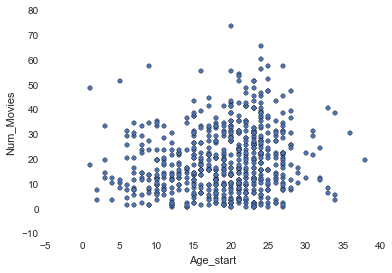

In [40]:
df.plot(x='Age_start',y='Num_Movies',kind="scatter")

In [189]:
### Scrape "Years active" data from Wikipedia

active = []
for actor in actors_3:
    new_name = actor.replace(" ","_")
    url = "https://en.wikipedia.org/wiki/"+new_name

    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"html.parser")

    try:
        for line in soup.find(class_=re.compile('infobox')).find_all(string=re.compile('^Years')):
            active.append((actor,line.find_next().string))
    except:
        try: 
            url = "https://en.wikipedia.org/wiki/"+new_name+"_(actor)"
            response = requests.get(url)
            page = response.text
            soup = BeautifulSoup(page,"html.parser")
            for line in soup.find(class_=re.compile('infobox')).find_all(string=re.compile('^Years')):
                active.append((actor,line.find_next().string))
        except:
            active.append((actor,"None"))

#### Create list of strings of "Years active" data    
    l = []
    for name,years in active:
        if years!=None:
            l.append((name,unicode(years).encode("ascii","ignore")))
            
#### Separate "Years active" data into start and finish year 
    list_years_active = []
    for k,v in l:
        start,finish = v[:4],v[4:]
        list_years_active.append([k,start,finish])

In [4]:
with open('actors_only.pkl', 'r') as picklefile:
    df = pickle.load(picklefile)

#### Check missing values
    actors_3 = list(df[df['Career_start'].isnull()].Actor)
    len(actors_3)

#### Merged career start/finish data from separate scrape
    for l in list_years_active:
        df.set_value(df[df['Actor']==l[0]].index, 'Career_start', l[1])

In [297]:
#### Convert date of career start to integer
df['Career_start'] = df['Career_start'].map(lambda x: int(x) if str(x).isdigit() else None)

In [254]:
codebook = {
    "Actor": "unique ID",
    "Total_Gross_2015_Dol": "Amount grossed by films featuring this actor",
    "Num_movies": "Number of movies used to calculate total gross",
    "Avg_Gross": "Total gross divided by number of movies",
    "Oscar": "Dummy variable 1 for Oscar win/nomination",
    "Birthday": "Actor's birthday (datetime object)",
    "Occupation": "Individual's occupation (source: Wikipedia)",
    "Gender": "Actor's gender based on Actor/Actress designation",    
    "Occ_act_dummy": "Dummy variable 1 for actor as primary occupation (source: Wikipedia)",
    "Num_months_rec_pd_15_20": "Count of months in US economic recession between ages 15-20",
    "Num_months_rec_pd_0_15": "Count of months in US economic recession between ages 0-15",
    "Age": "Age of actor",
    "Career_start": "Year acting career began (source: Wikipedia)",
    "Career_fin": "Year acting career ended (source: Wikipedia)"
}

In [311]:
df_only_actors['Age_start'] = df_only_actors['Career_start'] - (2015 - df_only_actors['Age'])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
df.head()

,Actor,Total_Gross_2015_Dol,Num_Movies,Avg_Gross,Oscar,Birthday,Occupation,Gender,Occ_act_dummy,Num_months_rec_pd_15_20,Num_months_rec_pd_0_15,Age,Career_start,Career_fin,Age_start,Num_months_rec_pd_0_5,Num_months_rec_pd_5_10,Num_months_rec_pd_10_15,Num_months_rec_pd_20_25,Years_acting
0,Harrison Ford,8116.1,40,202.902500,1,1942-07-13,"Actor, producer",0,1,18,29,73,1966,present,24,8,11,10,0,49
1,Tom Hanks,6676.6,42,158.966667,1,1956-07-09,"Actor, filmmaker",0,1,16,29,59,1978,present,22,18,0,11,6,37
2,Samuel L. Jackson,5722.3,66,86.701515,1,1948-12-21,"Actor, film producer",0,1,0,39,67,1972,present,24,15,14,10,11,43
3,Morgan Freeman,5587.5,58,96.336207,1,1937-06-01,"Actor, director",0,1,10,19,78,1964,present,27,0,8,11,18,51
4,Tom Cruise,5456.0,35,155.885714,1,1962-07-03,"Actor, filmmaker",0,1,17,27,53,1981,present,19,0,11,16,5,34


In [10]:
df['Num_months_rec_pd_0_5']=df['Birthday'].map(lambda x: count_rec_pd(age_range(x,0,5)))
df['Num_months_rec_pd_5_10']=df['Birthday'].map(lambda x: count_rec_pd(age_range(x,5,10)))
df['Num_months_rec_pd_10_15']=df['Birthday'].map(lambda x: count_rec_pd(age_range(x,10,15)))
df['Num_months_rec_pd_20_25']=df['Birthday'].map(lambda x: count_rec_pd(age_range(x,20,25)))

In [17]:
df['Num_months_rec_pd_15_20']=df['Birthday'].map(lambda x: count_rec_pd(age_range(x,15,20)))

In [24]:
df['Years_acting']=df['Age']-df['Age_start']

In [53]:
y, X = dmatrices('Avg_Gross ~ Years_acting + Gender + Num_Movies + Oscar + Num_months_rec_pd_0_5 + Num_months_rec_pd_5_10 + Num_months_rec_pd_10_15 + Num_months_rec_pd_15_20 + Num_months_rec_pd_20_25', data=df_2, return_type='dataframe')

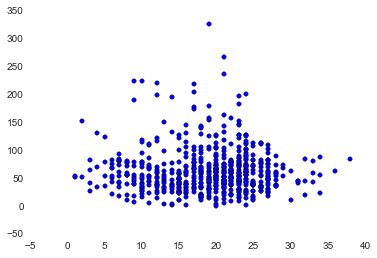

In [17]:
plt.scatter(df.Age_start,df.Avg_Gross)

In [31]:
df_2 = df[np.isfinite(df['Age_start'])]

In [54]:
fit = sm.OLS(y, X).fit()

In [55]:
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:              Avg_Gross   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.376
Date:                Tue, 14 Jul 2015   Prob (F-statistic):           1.49e-05
Time:                        11:44:59   Log-Likelihood:                -3132.7
No. Observations:                 617   AIC:                             6285.
Df Residuals:                     607   BIC:                             6330.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

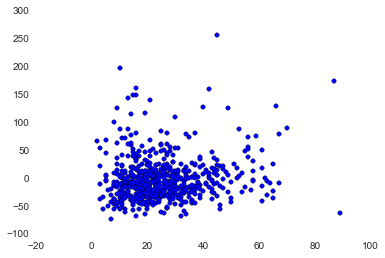

In [38]:
plt.scatter(df_2.Years_acting,fit.resid)

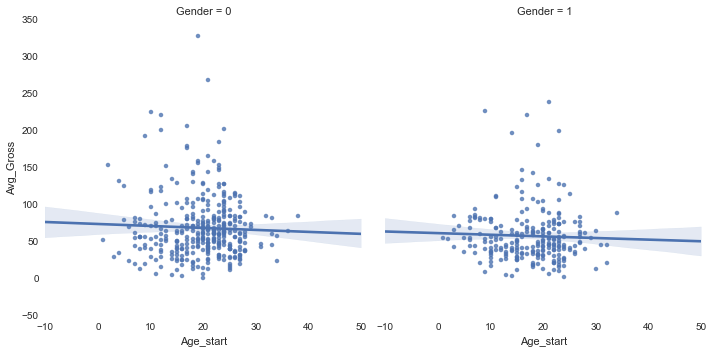

In [58]:
sns.lmplot(x="Age_start", y="Avg_Gross",
           col="Gender", data=df_2)

In [65]:
gb = df.groupby('Age_start')

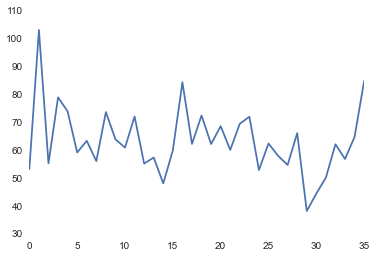

In [66]:
plt.plot(gb.Avg_Gross.mean())

<Container object of 2 artists>

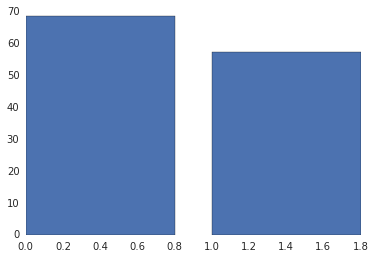

In [393]:
ind = np.arange(2) 
plt.bar(ind,gb.Avg_Gross.mean())

In [17]:
df = df.reset_index(drop=True)

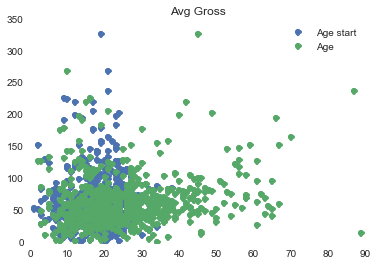

In [18]:
fig, ax = plt.subplots()
ax.plot(df.Age_start, df.Avg_Gross, 'o', label="Age start")
#ax.plot(df.Num_Movies, df.Avg_Gross, 'o', label="Num Movies")
ax.plot(df.Years_acting, df.Avg_Gross, 'o', label="Age")
ax.legend(loc="best")
plt.title("Avg Gross")

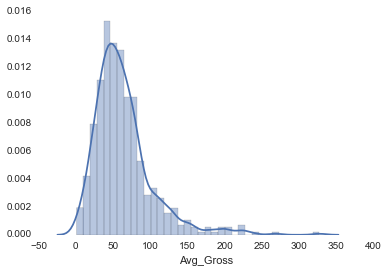

In [32]:
# Distribution of dependent variable (Avg_Gross)
sns.distplot(df.Avg_Gross)

In [20]:
df_a = df.groupby('Age')

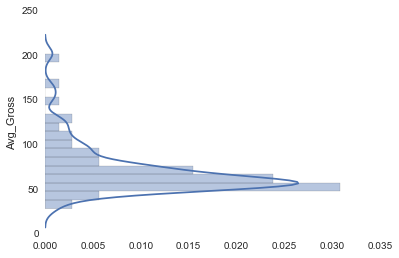

In [25]:
sns.distplot(df_a.Avg_Gross.mean(),vertical=True)

In [29]:
len(df.Avg_Gross)

626

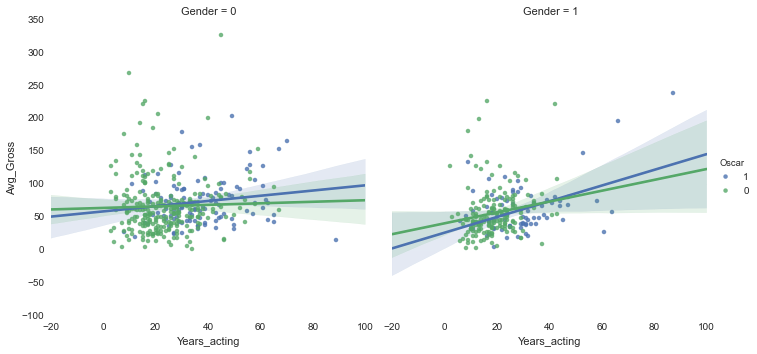

In [79]:
# More years acting are positively correlated with higher average gross of movies for women
sns.lmplot(x="Years_acting", y="Avg_Gross", hue="Oscar", col = "Gender", data=df)

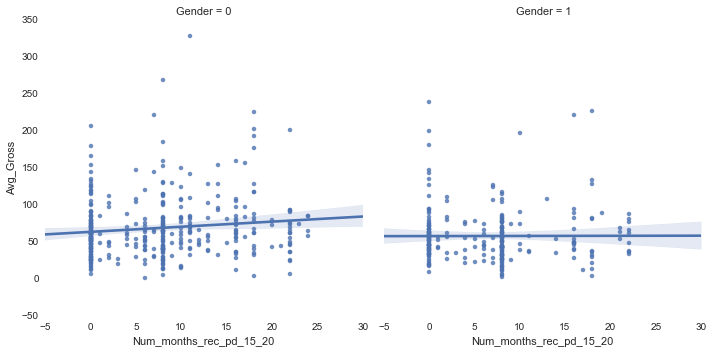

In [8]:
sns.lmplot(x="Num_months_rec_pd_15_20", y="Avg_Gross", col = "Gender", data=df)

In [60]:
with open('actors_only_2.pkl','w') as picklefile:
    pickle.dump(df_2,picklefile)

In [3]:
with open('actors_only_2.pkl','r') as picklefile:
    df = pickle.load(picklefile)

In [18]:
df.head()

,Actor,Total_Gross_2015_Dol,Num_Movies,Avg_Gross,Oscar,Birthday,Occupation,Gender,Occ_act_dummy,Num_months_rec_pd_15_20,Num_months_rec_pd_0_15,Age,Career_start,Career_fin,Age_start,Num_months_rec_pd_0_5,Num_months_rec_pd_5_10,Num_months_rec_pd_10_15,Num_months_rec_pd_20_25,Years_acting
0,Harrison Ford,8116.1,40,202.902500,1,1942-07-13,"Actor, producer",0,1,18,29,73,1966,present,24,8,11,10,0,49
1,Tom Hanks,6676.6,42,158.966667,1,1956-07-09,"Actor, filmmaker",0,1,16,29,59,1978,present,22,18,0,11,6,37
2,Samuel L. Jackson,5722.3,66,86.701515,1,1948-12-21,"Actor, film producer",0,1,0,39,67,1972,present,24,15,14,10,11,43
3,Morgan Freeman,5587.5,58,96.336207,1,1937-06-01,"Actor, director",0,1,10,19,78,1964,present,27,0,8,11,18,51
4,Tom Cruise,5456.0,35,155.885714,1,1962-07-03,"Actor, filmmaker",0,1,17,27,53,1981,present,19,0,11,16,5,34


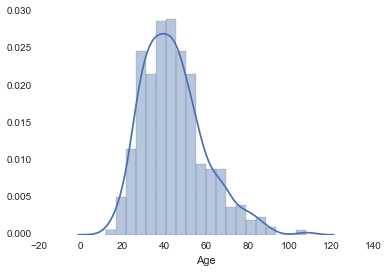

In [24]:
sns.distplot(df.Age,bins=20)